# DQN Training for Fire-Rescue Environment

#### Deep Q-Network - Value-Based Reinforcement Learning
 
This notebook includes:
 - 10+ hyperparameter configurations
 - Training with different settings
 - Logging and visualization
 - Model saving and evaluation

In [1]:
!pip install gymnasium stable-baselines3 tensorboard matplotlib pandas seaborn tqdm

In [2]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 2: Import Libraries
# ═══════════════════════════════════════════════════════════════════════
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Stable Baselines
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Add project root to path
project_root = Path.cwd().parent if 'training' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

# Import custom environment
from environment.custom_env import FireRescueEnv

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

print("✓ All libraries imported successfully")
print(f"✓ Project root: {project_root}")

✓ All libraries imported successfully
✓ Project root: c:\Users\HP\Programming\ML\fire_rescue_agent


In [3]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 3: Setup Directories
# ═══════════════════════════════════════════════════════════════════════
"""
Create necessary directories for models and logs
"""
# Create directory structure
base_dir = project_root / "models" / "dqn"
logs_dir = base_dir / "training_logs"
tensorboard_dir = base_dir / "tensorboard"
results_dir = project_root / "results"
plots_dir = results_dir / "plots"

for directory in [base_dir, logs_dir, tensorboard_dir, results_dir, plots_dir]:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Directories created:")
print(f"  - Models: {base_dir}")
print(f"  - Logs: {logs_dir}")
print(f"  - Tensorboard: {tensorboard_dir}")
print(f"  - Results: {results_dir}")

✓ Directories created:
  - Models: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn
  - Logs: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\training_logs
  - Tensorboard: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard
  - Results: c:\Users\HP\Programming\ML\fire_rescue_agent\results


In [4]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 4: DQN HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════

DQN_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard settings"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - Fast learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Careful learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LARGE BATCH
    # ─────────────────────────────────────────────────────────────────────
    "config_4_large_batch": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 128,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Large Batch - Stable gradients"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: SMALL BATCH
    # ─────────────────────────────────────────────────────────────────────
    "config_5_small_batch": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 16,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Small Batch - Fast updates"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW GAMMA
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.95,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Short-term focus"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: HIGH GAMMA
    # ─────────────────────────────────────────────────────────────────────
    "config_7_high_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.995,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Gamma - Long-term planning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: FAST EXPLORATION DECAY
    # ─────────────────────────────────────────────────────────────────────
    "config_8_fast_decay": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.1,
        "exploration_fraction": 0.1,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Fast Decay - Quick exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: SLOW EXPLORATION DECAY
    # ─────────────────────────────────────────────────────────────────────
    "config_9_slow_decay": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.01,
        "exploration_fraction": 0.4,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Slow Decay - Extended exploration"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: OPTIMIZED
    # ─────────────────────────────────────────────────────────────────────
    "config_10_optimized": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.02,
        "exploration_fraction": 0.3,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[128, 128]),
        "description": "Optimized - Balanced settings"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 11: NO EXPLORATION
    # ─────────────────────────────────────────────────────────────────────
    "config_11_no_exploration": {
        "learning_rate": 1e-3,
        "gamma": 0.95,
        "batch_size": 32,
        "exploration_initial_eps": 0,
        "exploration_final_eps": 0,
        "exploration_fraction": 0.2,
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "No Exploration - Pure exploitation"
    }
}

# ═══════════════════════════════════════════════════════════════════════
# CONFIGURATION SUMMARY
# ═══════════════════════════════════════════════════════════════════════
print(f"Training {len(DQN_CONFIGS)} DQN configurations\n")
print("=" * 100)
print(f"{'Config':<30} {'LR':<10} {'Gamma':<8} {'Batch':<8} {'ε_start':<10} {'ε_end':<10} {'ε_decay':<10}")
print("=" * 100)

for config_name, config in DQN_CONFIGS.items():
    print(f"{config_name:<30} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['batch_size']:<8} {config['exploration_initial_eps']:<10.2f} "
          f"{config['exploration_final_eps']:<10.2f} {config['exploration_fraction']:<10.2f}")

print("=" * 100)

Training 11 DQN configurations

Config                         LR         Gamma    Batch    ε_start    ε_end      ε_decay   
config_1_baseline              1e-03      0.990    32       1.00       0.05       0.20      
config_2_high_lr               5e-03      0.990    32       1.00       0.05       0.20      
config_3_low_lr                1e-05      0.990    32       1.00       0.05       0.20      
config_4_large_batch           1e-03      0.990    128      1.00       0.05       0.20      
config_5_small_batch           1e-03      0.990    16       1.00       0.05       0.20      
config_6_low_gamma             1e-03      0.950    32       1.00       0.05       0.20      
config_7_high_gamma            1e-03      0.995    32       1.00       0.05       0.20      
config_8_fast_decay            1e-03      0.990    32       1.00       0.10       0.10      
config_9_slow_decay            1e-03      0.990    32       1.00       0.01       0.40      
config_10_optimized            3e-04  

## 🔥 CRITICAL BUG FIX - Scan Exploit

**Problem Identified:** The old model had 0% success rate because:
1. **Scan Exploit**: Scanning near survivor gave +0.5 reward
2. When agent **carries** survivor, it's always "near" the survivor  
3. Agent learned to **spam SCAN** instead of moving to door and dropping!

**Fix Applied:**
- ✅ Scan now gives **-0.2 penalty** when carrying survivor
- ✅ Scan only gives +0.5 reward when NOT carrying (for finding survivor)
- ✅ Added +0.5 bonus for being AT survivor location (encourages pickup)
- ✅ Added +1.0 bonus for being AT door while carrying (encourages drop)

**You MUST retrain** - the old model learned the exploit!

In [5]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 5: Training Configuration
# ═══════════════════════════════════════════════════════════════════════
"""
Set training parameters (matching PPO for fair comparison)

IMPORTANT: Environment now uses max_time=250 (updated from 200)
"""
# Training settings
TOTAL_TIMESTEPS = 100000  # Match PPO training timesteps
EVAL_FREQ = 5000          # Evaluate every N steps
N_EVAL_EPISODES = 10      # Number of episodes for evaluation
SAVE_FREQ = 10000         # Save model checkpoint every N steps

print("Training Configuration:")
print(f"  - Total Timesteps: {TOTAL_TIMESTEPS:,}")
print(f"  - Evaluation Frequency: {EVAL_FREQ:,}")
print(f"  - Evaluation Episodes: {N_EVAL_EPISODES}")
print(f"  - Checkpoint Frequency: {SAVE_FREQ:,}")
print(f"  - Environment max_time: 250 steps (updated from 200)")
print(f"\nNote: Timesteps match PPO training for fair comparison")

Training Configuration:
  - Total Timesteps: 100,000
  - Evaluation Frequency: 5,000
  - Evaluation Episodes: 10
  - Checkpoint Frequency: 10,000
  - Environment max_time: 250 steps (updated from 200)

Note: Timesteps match PPO training for fair comparison


In [6]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 6: Training Function
# ═══════════════════════════════════════════════════════════════════════
"""
Function to train a single DQN configuration
UPDATED: Uses max_time=250 for all environments
"""

def train_dqn_config(config_name, config, total_timesteps=TOTAL_TIMESTEPS):
    """
    Train DQN with given configuration
    
    Args:
        config_name: Name of the configuration
        config: Dictionary of hyperparameters
        total_timesteps: Total training steps
    
    Returns:
        Dictionary with training results
    """
    print(f"\n{'='*70}")
    print(f"Training: {config_name}")
    print(f"Description: {config['description']}")
    print(f"{'='*70}")
    
    # Create environment with UPDATED max_time=250
    env = FireRescueEnv(grid_size=10, max_time=250)  # UPDATED from 200
    env = Monitor(env)
    
    # Create eval environment
    eval_env = FireRescueEnv(grid_size=10, max_time=250)  # UPDATED from 200
    eval_env = Monitor(eval_env)
    
    # Create model directory for this config
    model_dir = base_dir / config_name
    model_dir.mkdir(exist_ok=True)
    
    # Setup callbacks
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=str(model_dir),
        log_path=str(logs_dir / config_name),
        eval_freq=EVAL_FREQ,
        n_eval_episodes=N_EVAL_EPISODES,
        deterministic=True,
        render=False,
        verbose=1
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ,
        save_path=str(model_dir / "checkpoints"),
        name_prefix="dqn_checkpoint",
        save_replay_buffer=True,
        save_vecnormalize=True
    )
    
    callback_list = CallbackList([eval_callback, checkpoint_callback])
    
    # Extract hyperparameters (remove description)
    train_config = {k: v for k, v in config.items() if k != 'description'}
    
    # Create DQN model
    model = DQN(
        "MlpPolicy",
        env,
        verbose=1,
        seed=SEED,
        tensorboard_log=str(tensorboard_dir / config_name),
        **train_config
    )
    
    # Train
    start_time = datetime.now()
    print(f"\nStarting training at {start_time.strftime('%H:%M:%S')}")
    
    try:
        model.learn(
            total_timesteps=total_timesteps,
            callback=callback_list,
            progress_bar=True
        )
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"\n✓ Training completed in {training_time:.1f} seconds")
        
        # Save final model
        final_model_path = model_dir / "final_model"
        model.save(str(final_model_path))
        print(f"✓ Model saved to {final_model_path}")
        
        # Final evaluation (100 episodes to match PPO)
        print("\nFinal evaluation (100 episodes)...")
        mean_reward, std_reward = evaluate_policy(
            model, 
            eval_env, 
            n_eval_episodes=100,
            deterministic=True
        )
        
        # ═══════════════════════════════════════════════════════════════════════
        # Calculate episode metrics (matching PPO)
        # ═══════════════════════════════════════════════════════════════════════
        print(f"Calculating episode performance metrics...")
        episode_rewards = []
        episode_lengths = []
        wall_collision_rates = []
        scan_efficiencies = []
        pickup_attempts_list = []
        time_to_find_survivor_list = []
        success_count = 0  # Track successes
        
        for episode_num in range(100):
            obs, _ = eval_env.reset()
            done = False
            
            while not done:
                action, _states = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = eval_env.step(action)
                done = terminated or truncated
            
            # Extract metrics from final info
            episode_rewards.append(info.get('episode_length', 0) * -0.01)  # Approximation
            episode_lengths.append(info.get('episode_length', 0))
            wall_collision_rates.append(info.get('wall_collision_rate', 0))
            scan_efficiencies.append(info.get('scan_efficiency', 0))
            pickup_attempts_list.append(info.get('pickup_attempts', 0))
            
            # Track success
            if info.get('success', False):
                success_count += 1
            
            time_found = info.get('time_to_find_survivor', None)
            if time_found is not None:
                time_to_find_survivor_list.append(time_found)
            
            # Debug output for first 5 episodes
            if episode_num < 5:
                success_str = "✓ SUCCESS" if info.get('success', False) else "✗ Failed"
                print(f"  Episode {episode_num+1}: {success_str} | "
                      f"Steps: {info.get('episode_length', 0)} | "
                      f"Wall Collisions: {info.get('wall_collision_rate', 0):.2%} | "
                      f"Scan Eff: {info.get('scan_efficiency', 0):.2%}")
        
        success_rate = success_count / 100
        print(f"\n📊 Evaluation Summary:")
        print(f"   🎯 SUCCESS RATE: {success_rate:.1%} ({success_count}/100)")
        print(f"   Average Episode Length: {np.mean(episode_lengths):.1f} steps")
        print(f"   Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
        print(f"   Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
        print(f"   Avg Pickup Attempts: {np.mean(pickup_attempts_list):.2f}")
        if time_to_find_survivor_list:
            print(f"   Avg Time to Find Survivor: {np.mean(time_to_find_survivor_list):.1f} steps ({len(time_to_find_survivor_list)}/100 found)")
        
        # Store results (matching PPO format)
        results = {
            'config_name': config_name,
            'description': config['description'],
            'mean_reward': mean_reward,
            'std_reward': std_reward,
            'success_rate': success_rate,  # NEW: Track success rate
            'success_count': success_count,  # NEW: Track success count
            'avg_episode_length': np.mean(episode_lengths),
            'wall_collision_rate': np.mean(wall_collision_rates),
            'scan_efficiency': np.mean(scan_efficiencies),
            'avg_pickup_attempts': np.mean(pickup_attempts_list),
            'avg_time_to_find_survivor': float(np.mean(time_to_find_survivor_list)) if time_to_find_survivor_list else None,
            'survivor_found_count': len(time_to_find_survivor_list),
            'training_time': training_time,
            'total_timesteps': total_timesteps,
            'hyperparameters': train_config
        }
        
        # Save results to JSON
        results_file = model_dir / "results.json"
        with open(results_file, 'w') as f:
            json_results = {
                'config_name': config_name,
                'description': config['description'],
                'mean_reward': float(mean_reward),
                'std_reward': float(std_reward),
                'success_rate': float(success_rate),  # NEW
                'success_count': success_count,  # NEW
                'avg_episode_length': float(np.mean(episode_lengths)),
                'wall_collision_rate': float(np.mean(wall_collision_rates)),
                'scan_efficiency': float(np.mean(scan_efficiencies)),
                'avg_pickup_attempts': float(np.mean(pickup_attempts_list)),
                'avg_time_to_find_survivor': float(np.mean(time_to_find_survivor_list)) if time_to_find_survivor_list else None,
                'survivor_found_count': len(time_to_find_survivor_list),
                'training_time': float(training_time),
                'total_timesteps': total_timesteps,
                'hyperparameters': {
                    k: (float(v) if isinstance(v, (np.floating, np.integer)) else v)
                    for k, v in train_config.items() if k != 'policy_kwargs'
                }
            }
            json.dump(json_results, f, indent=4)
        
        print(f"✓ Results saved to {results_file}")
        
        # Cleanup
        env.close()
        eval_env.close()
        
        return results
        
    except Exception as e:
        print(f"\n✗ Training failed: {e}")
        env.close()
        eval_env.close()
        return None

print("✓ Training function defined")

✓ Training function defined



In [7]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 7: Train All Configurations
# ═══════════════════════════════════════════════════════════════════════
"""
Train all DQN configurations
WARNING: This will take several hours!
"""

# Store all results
all_results = []

print(f"\n{'#'*70}")
print(f"STARTING FULL TRAINING RUN")
print(f"Training {len(DQN_CONFIGS)} configurations")
print(f"Estimated time: {len(DQN_CONFIGS) * 15} - {len(DQN_CONFIGS) * 30} minutes")
print(f"{'#'*70}\n")

# Train each configuration
for config_name, config in DQN_CONFIGS.items():
    results = train_dqn_config(config_name, config)
    
    if results:
        all_results.append(results)
        print(f"\n✓ Completed {len(all_results)}/{len(DQN_CONFIGS)} configurations")
    else:
        print(f"\n✗ Failed configuration: {config_name}")
    
    print(f"\n{'='*70}\n")

print(f"\n{'#'*70}")
print(f"TRAINING COMPLETE!")
print(f"Successfully trained: {len(all_results)}/{len(DQN_CONFIGS)} configurations")
print(f"{'#'*70}")


######################################################################
STARTING FULL TRAINING RUN
Training 11 configurations
Estimated time: 165 - 330 minutes
######################################################################


Training: config_1_baseline
Description: Baseline - Standard settings
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 17:27:41
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_1_baseline\DQN_1

Starting training at 17:27:41
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_1_baseline\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -78      |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2263     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1000     |
---------------------------

Eval num_timesteps=5000, episode_reward=-65.38 +/- 104.24

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -65.4    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00987  |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | -37      |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 396      |
|    time_elapsed     | 13       |
|    total_timesteps  | 5251     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0482   |
|    n_updates        | 1062     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 215      |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 397      |
|    time_elapsed     | 15       |
|    total_timesteps  | 6028     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0422   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-16.82 +/- 12.80

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -16.8    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00761  |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 213      |
|    ep_rew_mean      | -10.6    |
|    exploration_rate | 0.514    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 338      |
|    time_elapsed     | 30       |
|    total_timesteps  | 10225    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0228   |
|    n_updates        | 2306     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 208      |
|    ep_rew_mean      | -4.93    |
|    exploration_rate | 0.487    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 339      |
|    time_elapsed     | 31       |
|    total_timesteps  | 10801    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.032    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=5.22 +/- 33.65

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 5.22     |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0389   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | 18.6     |
|    exploration_rate | 0.254    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 359      |
|    time_elapsed     | 43       |
|    total_timesteps  | 15708    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0514   |
|    n_updates        | 3676     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | 20.6     |
|    exploration_rate | 0.212    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 367      |
|    time_elapsed     | 45       |
|    total_timesteps  | 16582    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0177   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=99.78 +/- 21.62

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 99.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.024    |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | 34.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 376      |
|    time_elapsed     | 54       |
|    total_timesteps  | 20471    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0229   |
|    n_updates        | 4867     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 193      |
|    ep_rew_mean      | 38.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 376      |
|    time_elapsed     | 56       |
|    total_timesteps  | 21289    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00961  |
|    n_updates      

Eval num_timesteps=25000, episode_reward=89.80 +/- 34.31

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 89.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0174   |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 58.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 372      |
|    time_elapsed     | 69       |
|    total_timesteps  | 25779    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.497    |
|    n_updates        | 6194     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=93.42 +/- 22.72

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 93.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.501    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 72.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 373      |
|    time_elapsed     | 81       |
|    total_timesteps  | 30267    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0365   |
|    n_updates        | 7316     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=76.53 +/- 49.77

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 76.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.22     |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 217      |
|    ep_rew_mean      | 78.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 172      |
|    fps              | 373      |
|    time_elapsed     | 96       |
|    total_timesteps  | 35882    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0158   |
|    n_updates        | 8720     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=71.22 +/- 49.53

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 71.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0118   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 216      |
|    ep_rew_mean      | 85.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 376      |
|    time_elapsed     | 107      |
|    total_timesteps  | 40586    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.023    |
|    n_updates        | 9896     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=52.41 +/- 52.51

Episode length: 225.80 +/- 72.60

----------------------------------
| eval/               |          |
|    mean_ep_length   | 226      |
|    mean_reward      | 52.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0223   |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 209      |
|    ep_rew_mean      | 92.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 224      |
|    fps              | 381      |
|    time_elapsed     | 119      |
|    total_timesteps  | 45800    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.384    |
|    n_updates        | 11199    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=112.07 +/- 7.40

Episode length: 233.40 +/- 49.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 233      |
|    mean_reward      | 112      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.01     |
|    n_updates        | 12249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 98.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 248      |
|    fps              | 383      |
|    time_elapsed     | 130      |
|    total_timesteps  | 50135    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0211   |
|    n_updates        | 12283    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 97.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 386      |
|    time_elapsed     | 131      |
|    total_timesteps  | 50946    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0505   |
|    n_updates      

Eval num_timesteps=55000, episode_reward=103.56 +/- 11.95

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 104      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.505    |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 193      |
|    ep_rew_mean      | 95.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 391      |
|    time_elapsed     | 140      |
|    total_timesteps  | 55213    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0158   |
|    n_updates        | 13553    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=55.17 +/- 109.79

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 55.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0575   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 190      |
|    ep_rew_mean      | 98       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 300      |
|    fps              | 393      |
|    time_elapsed     | 154      |
|    total_timesteps  | 60578    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0386   |
|    n_updates        | 14894    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=108.18 +/- 3.29

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 108      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.119    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | 93.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 388      |
|    time_elapsed     | 168      |
|    total_timesteps  | 65393    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0101   |
|    n_updates        | 16098    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=55.03 +/- 94.99

Episode length: 179.00 +/- 108.47

----------------------------------
| eval/               |          |
|    mean_ep_length   | 179      |
|    mean_reward      | 55       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00287  |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | 90.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 384      |
|    time_elapsed     | 182      |
|    total_timesteps  | 70116    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0264   |
|    n_updates        | 17278    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=109.65 +/- 13.86

Episode length: 192.20 +/- 90.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 192      |
|    mean_reward      | 110      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.322    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | 84.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 394      |
|    time_elapsed     | 190      |
|    total_timesteps  | 75023    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0936   |
|    n_updates        | 18505    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=53.30 +/- 56.38

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 53.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0297   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 183      |
|    ep_rew_mean      | 77.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 408      |
|    fps              | 404      |
|    time_elapsed     | 198      |
|    total_timesteps  | 80227    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.425    |
|    n_updates        | 19806    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=77.91 +/- 46.35

Episode length: 201.80 +/- 96.40

----------------------------------
| eval/               |          |
|    mean_ep_length   | 202      |
|    mean_reward      | 77.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0646   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 77.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 403      |
|    time_elapsed     | 211      |
|    total_timesteps  | 85225    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.323    |
|    n_updates        | 21056    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=41.03 +/- 46.18

Episode length: 226.80 +/- 69.60

----------------------------------
| eval/               |          |
|    mean_ep_length   | 227      |
|    mean_reward      | 41       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.157    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 151      |
|    ep_rew_mean      | 81.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 403      |
|    time_elapsed     | 223      |
|    total_timesteps  | 90122    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.809    |
|    n_updates        | 22280    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=47.99 +/- 30.09

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 48       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0385   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 156      |
|    ep_rew_mean      | 72       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 504      |
|    fps              | 409      |
|    time_elapsed     | 232      |
|    total_timesteps  | 95187    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.11     |
|    n_updates        | 23546    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=-63.53 +/- 106.54

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -63.5    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.122    |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 244.6 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_1_baseline\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250

Eval num_timesteps=5000, episode_reward=4.97 +/- 23.95

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 4.97     |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0176   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 221      |
|    ep_rew_mean      | -30.4    |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 532      |
|    time_elapsed     | 9        |
|    total_timesteps  | 5307     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0268   |
|    n_updates        | 1076     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 216      |
|    ep_rew_mean      | -19.6    |
|    exploration_rate | 0.712    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 497      |
|    time_elapsed     | 12       |
|    total_timesteps  | 6057     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0509   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=36.79 +/- 70.44

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 36.8     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0237   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 194      |
|    ep_rew_mean      | 8.11     |
|    exploration_rate | 0.521    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 495      |
|    time_elapsed     | 20       |
|    total_timesteps  | 10078    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0453   |
|    n_updates        | 2269     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.49     |
| time/               |          |
|    episodes         | 56       |
|    fps              | 506      |
|    time_elapsed     | 21       |
|    total_timesteps  | 10737    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0448   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=93.43 +/- 32.79

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 93.4     |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0694   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 182      |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.274    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 530      |
|    time_elapsed     | 28       |
|    total_timesteps  | 15286    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0205   |
|    n_updates        | 3571     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 181      |
|    ep_rew_mean      | 35.3     |
|    exploration_rate | 0.242    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 534      |
|    time_elapsed     | 29       |
|    total_timesteps  | 15959    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0612   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=57.11 +/- 63.66

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 57.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.029    |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | 60.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 112      |
|    fps              | 532      |
|    time_elapsed     | 37       |
|    total_timesteps  | 20008    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.305    |
|    n_updates        | 4751     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=84.95 +/- 45.11

Episode length: 226.00 +/- 72.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 226      |
|    mean_reward      | 84.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0616   |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 75.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 140      |
|    fps              | 529      |
|    time_elapsed     | 48       |
|    total_timesteps  | 25430    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0821   |
|    n_updates        | 6107     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=64.62 +/- 55.82

Episode length: 184.80 +/- 62.29

----------------------------------
| eval/               |          |
|    mean_ep_length   | 185      |
|    mean_reward      | 64.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.465    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | 86.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 184      |
|    fps              | 525      |
|    time_elapsed     | 57       |
|    total_timesteps  | 30113    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.824    |
|    n_updates        | 7278     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=-123.00 +/- 130.71

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -123     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.144    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | 79.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 236      |
|    fps              | 528      |
|    time_elapsed     | 66       |
|    total_timesteps  | 35348    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.602    |
|    n_updates        | 8586     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=-79.01 +/- 98.80

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -79      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.43     |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | 67.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 532      |
|    time_elapsed     | 76       |
|    total_timesteps  | 40518    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.343    |
|    n_updates        | 9879     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=64.22 +/- 33.40

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 64.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.55     |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 71       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 533      |
|    time_elapsed     | 85       |
|    total_timesteps  | 45433    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.245    |
|    n_updates        | 11108    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=-35.18 +/- 95.96

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -35.2    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.4      |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 152      |
|    ep_rew_mean      | 66.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 528      |
|    time_elapsed     | 95       |
|    total_timesteps  | 50574    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.04     |
|    n_updates        | 12393    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=15.64 +/- 100.19

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 15.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.236    |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 175      |
|    ep_rew_mean      | 50.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 360      |
|    fps              | 527      |
|    time_elapsed     | 104      |
|    total_timesteps  | 55205    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0467   |
|    n_updates        | 13551    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=-49.61 +/- 126.71

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -49.6    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.154    |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 38.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 527      |
|    time_elapsed     | 113      |
|    total_timesteps  | 60131    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.14     |
|    n_updates        | 14782    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=23.66 +/- 83.54

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 23.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.402    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 186      |
|    ep_rew_mean      | 19.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 416      |
|    fps              | 529      |
|    time_elapsed     | 123      |
|    total_timesteps  | 65332    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.471    |
|    n_updates        | 16082    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=-8.79 +/- 55.35

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -8.79    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0295   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 188      |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 440      |
|    fps              | 529      |
|    time_elapsed     | 132      |
|    total_timesteps  | 70037    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.58     |
|    n_updates        | 17259    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=78.43 +/- 35.12

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 78.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.486    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | 7.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 468      |
|    fps              | 529      |
|    time_elapsed     | 143      |
|    total_timesteps  | 75808    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.195    |
|    n_updates        | 18701    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=-17.72 +/- 87.59

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -17.7    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.545    |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 205      |
|    ep_rew_mean      | 2.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 492      |
|    fps              | 530      |
|    time_elapsed     | 152      |
|    total_timesteps  | 80621    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.242    |
|    n_updates        | 19905    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=-66.58 +/- 118.51

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -66.6    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.303    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 528      |
|    time_elapsed     | 161      |
|    total_timesteps  | 85525    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.402    |
|    n_updates        | 21131    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=-9.46 +/- 36.24

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -9.46    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.03     |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 204      |
|    ep_rew_mean      | 9.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 540      |
|    fps              | 530      |
|    time_elapsed     | 170      |
|    total_timesteps  | 90422    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.245    |
|    n_updates        | 22355    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=-88.48 +/- 142.39

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -88.5    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.357    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 203      |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 564      |
|    fps              | 527      |
|    time_elapsed     | 180      |
|    total_timesteps  | 95148    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.48     |
|    n_updates        | 23536    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=-78.03 +/- 122.25

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -78      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.159    |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 189.3 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_2_high_lr\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 94.56% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 94.56% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps

Eval num_timesteps=5000, episode_reward=-24.43 +/- 0.50

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -24.4    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.129    |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -69.2    |
|    exploration_rate | 0.762    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 768      |
|    time_elapsed     | 6        |
|    total_timesteps  | 5000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 241      |
|    ep_rew_mean      | -61.4    |
|    exploration_rate | 0.726    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 753      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5778     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.111    |
|    n_updates        | 1194     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=10000, episode_reward=-56.46 +/- 70.47

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -56.5    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.065    |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 245      |
|    ep_rew_mean      | -60      |
|    exploration_rate | 0.488    |
| time/               |          |
|    episodes         | 44       |
|    fps              | 682      |
|    time_elapsed     | 15       |
|    total_timesteps  | 10778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0604   |
|    n_updates        | 2444     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=-10.04 +/- 40.72

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -10      |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0708   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 247      |
|    ep_rew_mean      | -58.1    |
|    exploration_rate | 0.251    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 647      |
|    time_elapsed     | 24       |
|    total_timesteps  | 15778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.327    |
|    n_updates        | 3694     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 247      |
|    ep_rew_mean      | -57.2    |
|    exploration_rate | 0.203    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 644      |
|    time_elapsed     | 26       |
|    total_timesteps  | 16778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0432   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=-10.53 +/- 40.85

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -10.5    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.055    |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 247      |
|    ep_rew_mean      | -53.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 84       |
|    fps              | 608      |
|    time_elapsed     | 34       |
|    total_timesteps  | 20778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0607   |
|    n_updates        | 4944     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=-19.45 +/- 7.71

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -19.4    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.346    |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 248      |
|    ep_rew_mean      | -50.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 567      |
|    time_elapsed     | 45       |
|    total_timesteps  | 25778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0467   |
|    n_updates        | 6194     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=-21.31 +/- 5.10

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -21.3    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0352   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -43.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 124      |
|    fps              | 498      |
|    time_elapsed     | 61       |
|    total_timesteps  | 30778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0826   |
|    n_updates        | 7444     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=-3.29 +/- 4.39

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -3.29    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.044    |
|    n_updates        | 8499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -33.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 144      |
|    fps              | 458      |
|    time_elapsed     | 78       |
|    total_timesteps  | 35778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0437   |
|    n_updates        | 8694     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 451      |
|    time_elapsed     | 81       |
|    total_timesteps  | 36778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0298   |
|    n_updates      

Eval num_timesteps=40000, episode_reward=-0.00 +/- 23.36

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -0.005   |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0245   |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -25.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 164      |
|    fps              | 431      |
|    time_elapsed     | 94       |
|    total_timesteps  | 40778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.336    |
|    n_updates        | 9944     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -25      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 168      |
|    fps              | 429      |
|    time_elapsed     | 97       |
|    total_timesteps  | 41778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0367   |
|    n_updates      

Eval num_timesteps=45000, episode_reward=-2.45 +/- 13.12

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -2.45    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.324    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -17.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 184      |
|    fps              | 418      |
|    time_elapsed     | 109      |
|    total_timesteps  | 45778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00978  |
|    n_updates        | 11194    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=27.06 +/- 48.04

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 27.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0387   |
|    n_updates        | 12249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -9.53    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 412      |
|    time_elapsed     | 122      |
|    total_timesteps  | 50778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0274   |
|    n_updates        | 12444    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -8.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 208      |
|    fps              | 412      |
|    time_elapsed     | 125      |
|    total_timesteps  | 51778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0209   |
|    n_updates      

Eval num_timesteps=55000, episode_reward=-10.03 +/- 9.05

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -10      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0429   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -4.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 224      |
|    fps              | 415      |
|    time_elapsed     | 134      |
|    total_timesteps  | 55778    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0246   |
|    n_updates        | 13694    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=-6.33 +/- 6.02

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -6.33    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0331   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -3.46    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 244      |
|    fps              | 416      |
|    time_elapsed     | 145      |
|    total_timesteps  | 60766    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00619  |
|    n_updates        | 14941    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=-8.79 +/- 10.74

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -8.79    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0273   |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -1.55    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 420      |
|    time_elapsed     | 156      |
|    total_timesteps  | 65766    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0155   |
|    n_updates        | 16191    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=-0.83 +/- 39.26

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -0.835   |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0383   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -3.04    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 284      |
|    fps              | 425      |
|    time_elapsed     | 166      |
|    total_timesteps  | 70766    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.312    |
|    n_updates        | 17441    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=1.23 +/- 38.05

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 1.23     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0107   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -2.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 431      |
|    time_elapsed     | 175      |
|    total_timesteps  | 75766    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0245   |
|    n_updates        | 18691    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=-14.11 +/- 11.88

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -14.1    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0299   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -5.08    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 438      |
|    time_elapsed     | 184      |
|    total_timesteps  | 80766    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0171   |
|    n_updates        | 19941    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=-16.61 +/- 11.49

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -16.6    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0302   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -5.09    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 344      |
|    fps              | 442      |
|    time_elapsed     | 193      |
|    total_timesteps  | 85766    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0163   |
|    n_updates        | 21191    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=-22.43 +/- 68.99

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -22.4    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0179   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -7.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 446      |
|    time_elapsed     | 203      |
|    total_timesteps  | 90766    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0504   |
|    n_updates        | 22441    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=-19.90 +/- 8.43

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -19.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0661   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -7.92    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 384      |
|    fps              | 451      |
|    time_elapsed     | 212      |
|    total_timesteps  | 95766    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.324    |
|    n_updates        | 23691    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=-28.26 +/- 23.25

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -28.3    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.333    |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 219.9 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_3_low_lr\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 96.17% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 96.17% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250

Eval num_timesteps=5000, episode_reward=23.85 +/- 47.21

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 23.9     |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0318   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 231      |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 696      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5550     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.171    |
|    n_updates        | 1137     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 28       |
|    fps              | 635      |
|    time_elapsed     | 10       |
|    total_timesteps  | 6520     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0194   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=25.76 +/- 80.11

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 25.8     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0263   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | -6.65    |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 48       |
|    fps              | 617      |
|    time_elapsed     | 17       |
|    total_timesteps  | 10524    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.631    |
|    n_updates        | 2380     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 220      |
|    ep_rew_mean      | -5.13    |
|    exploration_rate | 0.457    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 604      |
|    time_elapsed     | 18       |
|    total_timesteps  | 11433    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0226   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=67.48 +/- 55.89

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 67.5     |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0179   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.27     |
| time/               |          |
|    episodes         | 76       |
|    fps              | 584      |
|    time_elapsed     | 26       |
|    total_timesteps  | 15360    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.849    |
|    n_updates        | 3589     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | 24.9     |
|    exploration_rate | 0.25     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 579      |
|    time_elapsed     | 27       |
|    total_timesteps  | 15792    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0182   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=54.88 +/- 55.76

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 54.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0207   |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 181      |
|    ep_rew_mean      | 51.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 575      |
|    time_elapsed     | 34       |
|    total_timesteps  | 20066    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.01     |
|    n_updates        | 4766     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=62.56 +/- 58.54

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 62.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.352    |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 80.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 144      |
|    fps              | 569      |
|    time_elapsed     | 44       |
|    total_timesteps  | 25523    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.402    |
|    n_updates        | 6130     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=100.02 +/- 71.01

Episode length: 242.60 +/- 14.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 243      |
|    mean_reward      | 100      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.278    |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | 92.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 562      |
|    time_elapsed     | 53       |
|    total_timesteps  | 30179    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.61     |
|    n_updates        | 7294     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 151      |
|    ep_rew_mean      | 91       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 558      |
|    time_elapsed     | 55       |
|    total_timesteps  | 30893    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.468    |
|    n_updates      

Eval num_timesteps=35000, episode_reward=6.97 +/- 137.40

Episode length: 227.20 +/- 68.40

----------------------------------
| eval/               |          |
|    mean_ep_length   | 227      |
|    mean_reward      | 6.97     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.373    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | 96.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 212      |
|    fps              | 548      |
|    time_elapsed     | 64       |
|    total_timesteps  | 35647    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.247    |
|    n_updates        | 8661     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=83.80 +/- 52.30

Episode length: 186.20 +/- 99.34

----------------------------------
| eval/               |          |
|    mean_ep_length   | 186      |
|    mean_reward      | 83.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0968   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | 108      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 545      |
|    time_elapsed     | 74       |
|    total_timesteps  | 40478    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.443    |
|    n_updates        | 9869     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=110.46 +/- 28.84

Episode length: 175.70 +/- 102.11

----------------------------------
| eval/               |          |
|    mean_ep_length   | 176      |
|    mean_reward      | 110      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.687    |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | 107      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 284      |
|    fps              | 546      |
|    time_elapsed     | 82       |
|    total_timesteps  | 45144    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.268    |
|    n_updates        | 11035    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | 107      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 288      |
|    fps              | 542      |
|    time_elapsed     | 83       |
|    total_timesteps  | 45480    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.468    |
|    n_updates      

Eval num_timesteps=50000, episode_reward=78.29 +/- 51.88

Episode length: 226.40 +/- 70.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 226      |
|    mean_reward      | 78.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.604    |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 101      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 542      |
|    time_elapsed     | 92       |
|    total_timesteps  | 50374    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.898    |
|    n_updates        | 12343    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=-60.33 +/- 141.10

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -60.3    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.27     |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 146      |
|    ep_rew_mean      | 56.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 535      |
|    time_elapsed     | 104      |
|    total_timesteps  | 55917    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.609    |
|    n_updates        | 13729    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=-0.94 +/- 91.80

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -0.94    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.378    |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 168      |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 537      |
|    time_elapsed     | 113      |
|    total_timesteps  | 60744    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.842    |
|    n_updates        | 14935    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=-43.59 +/- 137.53

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -43.6    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0495   |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 182      |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 408      |
|    fps              | 537      |
|    time_elapsed     | 121      |
|    total_timesteps  | 65528    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.542    |
|    n_updates        | 16131    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=-103.15 +/- 98.83

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -103     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.144    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 189      |
|    ep_rew_mean      | -33.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 440      |
|    fps              | 537      |
|    time_elapsed     | 131      |
|    total_timesteps  | 70817    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0992   |
|    n_updates        | 17454    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=51.51 +/- 82.39

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 51.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.146    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 175      |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 464      |
|    fps              | 536      |
|    time_elapsed     | 140      |
|    total_timesteps  | 75383    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0805   |
|    n_updates        | 18595    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=36.14 +/- 93.75

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 36.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.124    |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 24.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 488      |
|    fps              | 521      |
|    time_elapsed     | 153      |
|    total_timesteps  | 80215    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.504    |
|    n_updates        | 19803    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=80.85 +/- 40.64

Episode length: 63.20 +/- 93.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 63.2     |
|    mean_reward      | 80.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.212    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | 66.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 556      |
|    fps              | 507      |
|    time_elapsed     | 167      |
|    total_timesteps  | 85001    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.246    |
|    n_updates        | 21000    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=103.85 +/- 47.58

Episode length: 87.50 +/- 104.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 87.5     |
|    mean_reward      | 104      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.564    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 75.1     |
|    ep_rew_mean      | 89.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 624      |
|    fps              | 491      |
|    time_elapsed     | 183      |
|    total_timesteps  | 90191    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.562    |
|    n_updates        | 22297    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=79.01 +/- 42.45

Episode length: 67.60 +/- 91.32

----------------------------------
| eval/               |          |
|    mean_ep_length   | 67.6     |
|    mean_reward      | 79       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.897    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.3     |
|    ep_rew_mean      | 91.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 732      |
|    fps              | 477      |
|    time_elapsed     | 199      |
|    total_timesteps  | 95294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.703    |
|    n_updates        | 23573    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=92.80 +/- 31.14

Episode length: 43.60 +/- 69.13

----------------------------------
| eval/               |          |
|    mean_ep_length   | 43.6     |
|    mean_reward      | 92.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0684   |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 213.5 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_4_large_batch\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✓ SUCCESS | Steps: 24 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✓ SUCCESS | Steps: 18 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✓ SUCCESS | Steps: 10 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✓ SUCCESS | Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: ✓ SUCCESS | Steps: 24 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✓ SUCCESS | Steps: 18 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✓ SUCCESS | Steps: 10 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✓ SUCCESS | Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 

Eval num_timesteps=5000, episode_reward=-45.91 +/- 103.07

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -45.9    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0703   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 224      |
|    ep_rew_mean      | -27      |
|    exploration_rate | 0.744    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 512      |
|    time_elapsed     | 10       |
|    total_timesteps  | 5383     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0297   |
|    n_updates        | 1095     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 214      |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.715    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 495      |
|    time_elapsed     | 12       |
|    total_timesteps  | 6006     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0664   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-12.54 +/- 61.29

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -12.5    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0362   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.516    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 427      |
|    time_elapsed     | 23       |
|    total_timesteps  | 10189    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0695   |
|    n_updates        | 2297     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.47     |
| time/               |          |
|    episodes         | 56       |
|    fps              | 417      |
|    time_elapsed     | 26       |
|    total_timesteps  | 11154    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.599    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=-35.03 +/- 114.92

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -35      |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.03     |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 21.1     |
|    exploration_rate | 0.248    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 398      |
|    time_elapsed     | 39       |
|    total_timesteps  | 15824    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0345   |
|    n_updates        | 3705     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=45.14 +/- 84.85

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 45.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0788   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | 38.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 387      |
|    time_elapsed     | 53       |
|    total_timesteps  | 20680    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0718   |
|    n_updates        | 4919     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | 44.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 384      |
|    time_elapsed     | 56       |
|    total_timesteps  | 21535    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0311   |
|    n_updates      

Eval num_timesteps=25000, episode_reward=42.41 +/- 55.19

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 42.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0165   |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 55.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 124      |
|    fps              | 376      |
|    time_elapsed     | 66       |
|    total_timesteps  | 25243    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0142   |
|    n_updates        | 6060     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=107.10 +/- 7.23

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 107      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0531   |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 215      |
|    ep_rew_mean      | 57.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 144      |
|    fps              | 374      |
|    time_elapsed     | 80       |
|    total_timesteps  | 30205    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0261   |
|    n_updates        | 7301     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 217      |
|    ep_rew_mean      | 55.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 373      |
|    time_elapsed     | 83       |
|    total_timesteps  | 31205    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0458   |
|    n_updates      

Eval num_timesteps=35000, episode_reward=54.81 +/- 51.19

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 54.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0369   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | 56.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 164      |
|    fps              | 371      |
|    time_elapsed     | 94       |
|    total_timesteps  | 35091    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.615    |
|    n_updates        | 8522     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=44.28 +/- 53.61

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 44.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00433  |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 235      |
|    ep_rew_mean      | 58.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 188      |
|    fps              | 369      |
|    time_elapsed     | 110      |
|    total_timesteps  | 40620    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0421   |
|    n_updates        | 9904     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=76.68 +/- 50.14

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 76.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00439  |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 235      |
|    ep_rew_mean      | 56.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 208      |
|    fps              | 367      |
|    time_elapsed     | 122      |
|    total_timesteps  | 45002    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0156   |
|    n_updates        | 11000    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=87.60 +/- 43.63

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 87.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.01     |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | 72.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 236      |
|    fps              | 365      |
|    time_elapsed     | 138      |
|    total_timesteps  | 50743    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0431   |
|    n_updates        | 12435    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=38.29 +/- 59.22

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 38.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0359   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | 73.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 256      |
|    fps              | 364      |
|    time_elapsed     | 151      |
|    total_timesteps  | 55353    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00417  |
|    n_updates        | 13588    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=86.01 +/- 46.61

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 86       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0268   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 217      |
|    ep_rew_mean      | 77.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 363      |
|    time_elapsed     | 165      |
|    total_timesteps  | 60380    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0122   |
|    n_updates        | 14844    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=10.52 +/- 139.08

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 10.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.324    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | 77.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 300      |
|    fps              | 362      |
|    time_elapsed     | 179      |
|    total_timesteps  | 65068    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00404  |
|    n_updates        | 16016    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=109.35 +/- 1.50

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 109      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00234  |
|    n_updates        | 17249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 221      |
|    ep_rew_mean      | 70.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 361      |
|    time_elapsed     | 194      |
|    total_timesteps  | 70361    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0569   |
|    n_updates        | 17340    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | 69       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 361      |
|    time_elapsed     | 196      |
|    total_timesteps  | 71065    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.07     |
|    n_updates      

Eval num_timesteps=75000, episode_reward=13.79 +/- 105.27

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 13.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0042   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 209      |
|    ep_rew_mean      | 71.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 357      |
|    time_elapsed     | 210      |
|    total_timesteps  | 75435    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00898  |
|    n_updates        | 18608    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=52.19 +/- 63.17

Episode length: 202.70 +/- 94.60

----------------------------------
| eval/               |          |
|    mean_ep_length   | 203      |
|    mean_reward      | 52.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00213  |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 203      |
|    ep_rew_mean      | 67.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 380      |
|    fps              | 356      |
|    time_elapsed     | 226      |
|    total_timesteps  | 80701    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.669    |
|    n_updates        | 19925    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=96.57 +/- 32.29

Episode length: 202.60 +/- 94.81

----------------------------------
| eval/               |          |
|    mean_ep_length   | 203      |
|    mean_reward      | 96.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00876  |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | 66.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 356      |
|    time_elapsed     | 239      |
|    total_timesteps  | 85574    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.927    |
|    n_updates        | 21143    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=35.67 +/- 57.11

Episode length: 235.60 +/- 43.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 236      |
|    mean_reward      | 35.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0245   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | 67.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 356      |
|    time_elapsed     | 253      |
|    total_timesteps  | 90246    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00565  |
|    n_updates        | 22311    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=87.43 +/- 45.81

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 87.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0998   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 184      |
|    ep_rew_mean      | 65.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 460      |
|    fps              | 356      |
|    time_elapsed     | 267      |
|    total_timesteps  | 95227    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.349    |
|    n_updates        | 23556    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=86.85 +/- 43.26

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 86.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0637   |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 280.8 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_5_small_batch\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Fa

Eval num_timesteps=5000, episode_reward=-79.68 +/- 79.70

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -79.7    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00902  |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | -36.7    |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 425      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5251     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0523   |
|    n_updates        | 1062     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | -33.5    |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 399      |
|    time_elapsed     | 15       |
|    total_timesteps  | 6225     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0366   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-4.18 +/- 38.56

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -4.18    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0249   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 214      |
|    ep_rew_mean      | -16.1    |
|    exploration_rate | 0.512    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 371      |
|    time_elapsed     | 27       |
|    total_timesteps  | 10268    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0245   |
|    n_updates        | 2316     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 217      |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.465    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 360      |
|    time_elapsed     | 31       |
|    total_timesteps  | 11265    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.314    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=-14.84 +/- 84.13

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -14.8    |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.514    |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | 12.7     |
|    exploration_rate | 0.272    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 344      |
|    time_elapsed     | 44       |
|    total_timesteps  | 15321    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0346   |
|    n_updates        | 3580     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=85.88 +/- 28.26

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 85.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0145   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 29.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 340      |
|    time_elapsed     | 58       |
|    total_timesteps  | 20018    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0786   |
|    n_updates        | 4754     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 36       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 334      |
|    time_elapsed     | 62       |
|    total_timesteps  | 20837    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0111   |
|    n_updates      

Eval num_timesteps=25000, episode_reward=72.68 +/- 44.97

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 72.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0318   |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 62.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 124      |
|    fps              | 328      |
|    time_elapsed     | 76       |
|    total_timesteps  | 25088    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0352   |
|    n_updates        | 6021     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=44.88 +/- 65.04

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 44.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00956  |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 206      |
|    ep_rew_mean      | 78.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 324      |
|    time_elapsed     | 94       |
|    total_timesteps  | 30860    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0213   |
|    n_updates        | 7464     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=33.06 +/- 105.65

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 33.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0317   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 216      |
|    ep_rew_mean      | 82.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 168      |
|    fps              | 320      |
|    time_elapsed     | 111      |
|    total_timesteps  | 35725    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0107   |
|    n_updates        | 8681     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=77.53 +/- 52.62

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 77.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0318   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | 81.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 192      |
|    fps              | 319      |
|    time_elapsed     | 126      |
|    total_timesteps  | 40431    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0755   |
|    n_updates        | 9857     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=51.89 +/- 112.29

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 51.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.031    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | 80.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 319      |
|    time_elapsed     | 140      |
|    total_timesteps  | 45049    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0266   |
|    n_updates        | 11012    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=96.33 +/- 39.94

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 96.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.107    |
|    n_updates        | 12249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 205      |
|    ep_rew_mean      | 78.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 244      |
|    fps              | 317      |
|    time_elapsed     | 158      |
|    total_timesteps  | 50409    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.147    |
|    n_updates        | 12352    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 204      |
|    ep_rew_mean      | 77.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 248      |
|    fps              | 316      |
|    time_elapsed     | 161      |
|    total_timesteps  | 51225    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.15     |
|    n_updates      

Eval num_timesteps=55000, episode_reward=73.62 +/- 54.55

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 73.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0654   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 188      |
|    ep_rew_mean      | 81.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 315      |
|    time_elapsed     | 175      |
|    total_timesteps  | 55175    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0332   |
|    n_updates        | 13543    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=84.65 +/- 45.64

Episode length: 204.20 +/- 91.61

----------------------------------
| eval/               |          |
|    mean_ep_length   | 204      |
|    mean_reward      | 84.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0306   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | 87.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 312      |
|    fps              | 314      |
|    time_elapsed     | 191      |
|    total_timesteps  | 60413    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.356    |
|    n_updates        | 14853    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=81.52 +/- 51.50

Episode length: 203.20 +/- 93.67

----------------------------------
| eval/               |          |
|    mean_ep_length   | 203      |
|    mean_reward      | 81.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.598    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 156      |
|    ep_rew_mean      | 89.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 340      |
|    fps              | 315      |
|    time_elapsed     | 206      |
|    total_timesteps  | 65195    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0555   |
|    n_updates        | 16048    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=51.95 +/- 54.37

Episode length: 181.60 +/- 104.68

----------------------------------
| eval/               |          |
|    mean_ep_length   | 182      |
|    mean_reward      | 51.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.354    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | 86       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 384      |
|    fps              | 312      |
|    time_elapsed     | 225      |
|    total_timesteps  | 70436    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.333    |
|    n_updates        | 17358    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=100.74 +/- 4.26

Episode length: 15.80 +/- 8.69

----------------------------------
| eval/               |          |
|    mean_ep_length   | 15.8     |
|    mean_reward      | 101      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.107    |
|    n_updates        | 18499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.6     |
|    ep_rew_mean      | 93.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 314      |
|    time_elapsed     | 239      |
|    total_timesteps  | 75186    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.068    |
|    n_updates        | 18546    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 83.1     |
|    ep_rew_mean      | 92       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 314      |
|    time_elapsed     | 239      |
|    total_timesteps  | 75323    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.039    |
|    n_updates      

Eval num_timesteps=80000, episode_reward=88.07 +/- 30.85

Episode length: 43.60 +/- 69.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 43.6     |
|    mean_reward      | 88.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0326   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 60       |
|    ep_rew_mean      | 98.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 314      |
|    time_elapsed     | 254      |
|    total_timesteps  | 80127    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.393    |
|    n_updates        | 19781    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=72.26 +/- 48.80

Episode length: 157.00 +/- 113.95

----------------------------------
| eval/               |          |
|    mean_ep_length   | 157      |
|    mean_reward      | 72.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.05     |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 64.2     |
|    ep_rew_mean      | 95.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 616      |
|    fps              | 313      |
|    time_elapsed     | 271      |
|    total_timesteps  | 85098    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0613   |
|    n_updates        | 21024    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=55.03 +/- 48.39

Episode length: 133.40 +/- 116.74

----------------------------------
| eval/               |          |
|    mean_ep_length   | 133      |
|    mean_reward      | 55       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.425    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.9     |
|    ep_rew_mean      | 102      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 313      |
|    time_elapsed     | 288      |
|    total_timesteps  | 90410    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.297    |
|    n_updates        | 22352    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=103.49 +/- 3.57

Episode length: 23.80 +/- 12.08

----------------------------------
| eval/               |          |
|    mean_ep_length   | 23.8     |
|    mean_reward      | 103      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0751   |
|    n_updates        | 23499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.9     |
|    ep_rew_mean      | 97       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 836      |
|    fps              | 315      |
|    time_elapsed     | 301      |
|    total_timesteps  | 95021    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0226   |
|    n_updates        | 23505    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.8     |
|    ep_rew_mean      | 97       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 314      |
|    time_elapsed     | 301      |
|    total_timesteps  | 95121    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0637   |
|    n_updates      

Eval num_timesteps=100000, episode_reward=84.81 +/- 42.20

Episode length: 73.80 +/- 88.64

----------------------------------
| eval/               |          |
|    mean_ep_length   | 73.8     |
|    mean_reward      | 84.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0647   |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 317.4 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_6_low_gamma\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✓ SUCCESS | Steps: 10 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✓ SUCCESS | Steps: 34 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✓ SUCCESS | Steps: 16 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✓ SUCCESS | Steps: 14 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✓ SUCCESS | Steps: 10 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✓ SUCCESS | Steps: 34 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✓ SUCCESS | Steps: 16 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✓ SUCCESS | Steps: 1

Eval num_timesteps=5000, episode_reward=-33.15 +/- 82.80

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -33.1    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0224   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 235      |
|    ep_rew_mean      | -41.1    |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 379      |
|    time_elapsed     | 14       |
|    total_timesteps  | 5646     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0361   |
|    n_updates        | 1161     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | -34.5    |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 28       |
|    fps              | 370      |
|    time_elapsed     | 17       |
|    total_timesteps  | 6528     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0379   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=3.18 +/- 74.02

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 3.18     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0104   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 214      |
|    ep_rew_mean      | -5.34    |
|    exploration_rate | 0.511    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 321      |
|    time_elapsed     | 31       |
|    total_timesteps  | 10294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0276   |
|    n_updates        | 2323     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 210      |
|    ep_rew_mean      | 0.314    |
|    exploration_rate | 0.482    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 320      |
|    time_elapsed     | 34       |
|    total_timesteps  | 10911    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0311   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=38.29 +/- 56.25

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 38.3     |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0186   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 201      |
|    ep_rew_mean      | 15.8     |
|    exploration_rate | 0.275    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 313      |
|    time_elapsed     | 48       |
|    total_timesteps  | 15269    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0157   |
|    n_updates        | 3567     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 19.6     |
|    exploration_rate | 0.239    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 311      |
|    time_elapsed     | 51       |
|    total_timesteps  | 16031    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.513    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=42.33 +/- 49.83

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 42.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0387   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 188      |
|    ep_rew_mean      | 51.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 304      |
|    time_elapsed     | 68       |
|    total_timesteps  | 20836    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.38     |
|    n_updates        | 4958     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 184      |
|    ep_rew_mean      | 58       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 112      |
|    fps              | 302      |
|    time_elapsed     | 70       |
|    total_timesteps  | 21441    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.89     |
|    n_updates      

Eval num_timesteps=25000, episode_reward=106.93 +/- 4.98

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 107      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0206   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 188      |
|    ep_rew_mean      | 71.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 302      |
|    time_elapsed     | 83       |
|    total_timesteps  | 25352    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0203   |
|    n_updates        | 6087     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 189      |
|    ep_rew_mean      | 75.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 300      |
|    time_elapsed     | 87       |
|    total_timesteps  | 26352    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0495   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=21.83 +/- 131.67

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 21.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.507    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 82.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 294      |
|    time_elapsed     | 102      |
|    total_timesteps  | 30267    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0908   |
|    n_updates        | 7316     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=51.75 +/- 52.69

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 51.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0378   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 215      |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 172      |
|    fps              | 293      |
|    time_elapsed     | 122      |
|    total_timesteps  | 35802    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0437   |
|    n_updates        | 8700     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=53.03 +/- 57.35

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 53       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0745   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 224      |
|    ep_rew_mean      | 91.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 192      |
|    fps              | 297      |
|    time_elapsed     | 135      |
|    total_timesteps  | 40173    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.016    |
|    n_updates        | 9793     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=96.36 +/- 32.58

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 96.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0202   |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 232      |
|    ep_rew_mean      | 90.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 298      |
|    time_elapsed     | 152      |
|    total_timesteps  | 45523    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.476    |
|    n_updates        | 11130    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=68.13 +/- 99.61

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 68.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0311   |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 223      |
|    ep_rew_mean      | 95.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 240      |
|    fps              | 294      |
|    time_elapsed     | 172      |
|    total_timesteps  | 50672    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.172    |
|    n_updates        | 12417    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=76.17 +/- 50.46

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 76.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0191   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 223      |
|    ep_rew_mean      | 89.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 298      |
|    time_elapsed     | 185      |
|    total_timesteps  | 55253    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.242    |
|    n_updates        | 13563    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=61.02 +/- 60.31

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 61       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0129   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | 85.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 284      |
|    fps              | 301      |
|    time_elapsed     | 199      |
|    total_timesteps  | 60199    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.378    |
|    n_updates        | 14799    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=84.00 +/- 43.17

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 84       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.647    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 218      |
|    ep_rew_mean      | 82.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 298      |
|    time_elapsed     | 219      |
|    total_timesteps  | 65340    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00688  |
|    n_updates        | 16084    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=85.27 +/- 48.59

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 85.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0136   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 211      |
|    ep_rew_mean      | 82.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 296      |
|    time_elapsed     | 236      |
|    total_timesteps  | 70115    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0218   |
|    n_updates        | 17278    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=72.74 +/- 49.04

Episode length: 230.90 +/- 57.30

----------------------------------
| eval/               |          |
|    mean_ep_length   | 231      |
|    mean_reward      | 72.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0229   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | 87.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 360      |
|    fps              | 300      |
|    time_elapsed     | 250      |
|    total_timesteps  | 75409    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.141    |
|    n_updates        | 18602    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=50.34 +/- 106.83

Episode length: 165.20 +/- 104.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 165      |
|    mean_reward      | 50.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0629   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 184      |
|    ep_rew_mean      | 91.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 307      |
|    time_elapsed     | 260      |
|    total_timesteps  | 80298    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.044    |
|    n_updates        | 19824    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=-137.49 +/- 140.74

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -137     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0399   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 88.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 424      |
|    fps              | 308      |
|    time_elapsed     | 275      |
|    total_timesteps  | 85026    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.108    |
|    n_updates        | 21006    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=-85.95 +/- 159.77

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -86      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.247    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | 73.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 305      |
|    time_elapsed     | 296      |
|    total_timesteps  | 90578    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0704   |
|    n_updates        | 22394    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=73.08 +/- 39.22

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 73.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.311    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 72.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 484      |
|    fps              | 305      |
|    time_elapsed     | 313      |
|    total_timesteps  | 95608    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.278    |
|    n_updates        | 23651    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=47.07 +/- 39.78

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 47.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00534  |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 329.0 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_7_high_gamma\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Step

Eval num_timesteps=5000, episode_reward=-6.54 +/- 10.57

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -6.54    |
| rollout/            |          |
|    exploration_rate | 0.55     |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0325   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 240      |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.482    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 499      |
|    time_elapsed     | 11       |
|    total_timesteps  | 5760     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0237   |
|    n_updates        | 1189     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 241      |
|    ep_rew_mean      | -30      |
|    exploration_rate | 0.394    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 462      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6735     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.029    |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-39.85 +/- 117.83

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -39.9    |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.053    |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 228      |
|    ep_rew_mean      | -10.1    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 48       |
|    fps              | 402      |
|    time_elapsed     | 27       |
|    total_timesteps  | 10946    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0167   |
|    n_updates        | 2486     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=20.07 +/- 47.61

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 20.1     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.309    |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | 4.49     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 68       |
|    fps              | 386      |
|    time_elapsed     | 41       |
|    total_timesteps  | 15861    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00522  |
|    n_updates        | 3715     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 229      |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 72       |
|    fps              | 379      |
|    time_elapsed     | 43       |
|    total_timesteps  | 16510    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0289   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=35.67 +/- 61.24

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 35.7     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.331    |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 221      |
|    ep_rew_mean      | 27.2     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 92       |
|    fps              | 367      |
|    time_elapsed     | 55       |
|    total_timesteps  | 20339    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0237   |
|    n_updates        | 4834     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 221      |
|    ep_rew_mean      | 28.3     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 96       |
|    fps              | 365      |
|    time_elapsed     | 58       |
|    total_timesteps  | 21240    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0206   |
|    n_updates      

Eval num_timesteps=25000, episode_reward=91.90 +/- 37.51

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 91.9     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0154   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 217      |
|    ep_rew_mean      | 52.6     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 116      |
|    fps              | 362      |
|    time_elapsed     | 70       |
|    total_timesteps  | 25590    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00271  |
|    n_updates        | 6147     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 215      |
|    ep_rew_mean      | 56.7     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 120      |
|    fps              | 360      |
|    time_elapsed     | 73       |
|    total_timesteps  | 26399    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00719  |
|    n_updates      

Eval num_timesteps=30000, episode_reward=76.65 +/- 49.66

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 76.6     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0195   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 214      |
|    ep_rew_mean      | 70.3     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 140      |
|    fps              | 364      |
|    time_elapsed     | 83       |
|    total_timesteps  | 30430    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0241   |
|    n_updates        | 7357     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=62.01 +/- 51.45

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 62       |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0166   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 209      |
|    ep_rew_mean      | 84.3     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 164      |
|    fps              | 368      |
|    time_elapsed     | 97       |
|    total_timesteps  | 35765    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.49     |
|    n_updates        | 8691     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=96.00 +/- 32.80

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 96       |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0146   |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 207      |
|    ep_rew_mean      | 89.4     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 188      |
|    fps              | 373      |
|    time_elapsed     | 107      |
|    total_timesteps  | 40332    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0961   |
|    n_updates        | 9832     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 205      |
|    ep_rew_mean      | 89.3     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 192      |
|    fps              | 373      |
|    time_elapsed     | 109      |
|    total_timesteps  | 40835    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00543  |
|    n_updates      

Eval num_timesteps=45000, episode_reward=37.68 +/- 61.60

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 37.7     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00705  |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 184      |
|    ep_rew_mean      | 97       |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 224      |
|    fps              | 376      |
|    time_elapsed     | 120      |
|    total_timesteps  | 45502    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0131   |
|    n_updates        | 11125    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=92.64 +/- 33.60

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 92.6     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0219   |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | 104      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 260      |
|    fps              | 378      |
|    time_elapsed     | 132      |
|    total_timesteps  | 50166    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.771    |
|    n_updates        | 12291    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=64.92 +/- 50.93

Episode length: 203.00 +/- 94.03

----------------------------------
| eval/               |          |
|    mean_ep_length   | 203      |
|    mean_reward      | 64.9     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0112   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | 90.8     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 300      |
|    fps              | 374      |
|    time_elapsed     | 147      |
|    total_timesteps  | 55256    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.245    |
|    n_updates        | 13563    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=61.18 +/- 49.80

Episode length: 132.40 +/- 117.61

----------------------------------
| eval/               |          |
|    mean_ep_length   | 132      |
|    mean_reward      | 61.2     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0396   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | 81.6     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 340      |
|    fps              | 380      |
|    time_elapsed     | 157      |
|    total_timesteps  | 60062    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.506    |
|    n_updates        | 14765    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=82.42 +/- 43.61

Episode length: 155.40 +/- 115.99

----------------------------------
| eval/               |          |
|    mean_ep_length   | 155      |
|    mean_reward      | 82.4     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.113    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.5     |
|    ep_rew_mean      | 78.8     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 404      |
|    fps              | 375      |
|    time_elapsed     | 173      |
|    total_timesteps  | 65312    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.961    |
|    n_updates        | 16077    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=-184.07 +/- 70.93

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -184     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0712   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.9     |
|    ep_rew_mean      | 69       |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 456      |
|    fps              | 375      |
|    time_elapsed     | 186      |
|    total_timesteps  | 70055    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.87     |
|    n_updates        | 17263    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=34.66 +/- 56.07

Episode length: 156.00 +/- 115.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 156      |
|    mean_reward      | 34.7     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.152    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.2     |
|    ep_rew_mean      | 67.5     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 516      |
|    fps              | 378      |
|    time_elapsed     | 198      |
|    total_timesteps  | 75136    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.605    |
|    n_updates        | 18533    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=84.03 +/- 48.99

Episode length: 204.80 +/- 90.44

----------------------------------
| eval/               |          |
|    mean_ep_length   | 205      |
|    mean_reward      | 84       |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.279    |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 75.8     |
|    ep_rew_mean      | 79.7     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 584      |
|    fps              | 380      |
|    time_elapsed     | 210      |
|    total_timesteps  | 80001    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.171    |
|    n_updates        | 19750    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=82.39 +/- 47.80

Episode length: 158.20 +/- 112.72

----------------------------------
| eval/               |          |
|    mean_ep_length   | 158      |
|    mean_reward      | 82.4     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.162    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 86       |
|    ep_rew_mean      | 85.1     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 632      |
|    fps              | 380      |
|    time_elapsed     | 223      |
|    total_timesteps  | 85166    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.535    |
|    n_updates        | 21041    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=78.60 +/- 44.58

Episode length: 131.80 +/- 118.30

----------------------------------
| eval/               |          |
|    mean_ep_length   | 132      |
|    mean_reward      | 78.6     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.588    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | 90.5     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 684      |
|    fps              | 382      |
|    time_elapsed     | 235      |
|    total_timesteps  | 90008    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.117    |
|    n_updates        | 22251    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=86.73 +/- 37.94

Episode length: 120.40 +/- 105.82

----------------------------------
| eval/               |          |
|    mean_ep_length   | 120      |
|    mean_reward      | 86.7     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.914    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99       |
|    ep_rew_mean      | 98.6     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 736      |
|    fps              | 382      |
|    time_elapsed     | 249      |
|    total_timesteps  | 95363    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0674   |
|    n_updates        | 23590    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=51.96 +/- 60.25

Episode length: 163.00 +/- 87.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 163      |
|    mean_reward      | 52       |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.183    |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 260.9 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_8_fast_decay\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✓ SUCCESS | Steps: 66 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✓ SUCCESS | Steps: 66 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✓ SUCCESS | Steps: 66 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✓ SUCCESS | Steps: 66 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 2

Eval num_timesteps=5000, episode_reward=-7.20 +/- 10.07

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -7.2     |
| rollout/            |          |
|    exploration_rate | 0.876    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0226   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 240      |
|    ep_rew_mean      | -54.3    |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 593      |
|    time_elapsed     | 9        |
|    total_timesteps  | 5751     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0116   |
|    n_updates        | 1187     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 239      |
|    ep_rew_mean      | -49.9    |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 584      |
|    time_elapsed     | 11       |
|    total_timesteps  | 6687     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0168   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-84.91 +/- 95.71

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -84.9    |
| rollout/            |          |
|    exploration_rate | 0.753    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00737  |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 232      |
|    ep_rew_mean      | -34.3    |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 44       |
|    fps              | 471      |
|    time_elapsed     | 21       |
|    total_timesteps  | 10220    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0218   |
|    n_updates        | 2304     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=-2.27 +/- 114.24

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -2.27    |
| rollout/            |          |
|    exploration_rate | 0.629    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0256   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 215      |
|    ep_rew_mean      | -10.7    |
|    exploration_rate | 0.617    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 428      |
|    time_elapsed     | 36       |
|    total_timesteps  | 15492    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0169   |
|    n_updates        | 3622     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 208      |
|    ep_rew_mean      | -5.43    |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 425      |
|    time_elapsed     | 37       |
|    total_timesteps  | 15842    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0155   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=-44.85 +/- 69.55

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -44.9    |
| rollout/            |          |
|    exploration_rate | 0.505    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0324   |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 204      |
|    ep_rew_mean      | 6.22     |
|    exploration_rate | 0.496    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 395      |
|    time_elapsed     | 51       |
|    total_timesteps  | 20377    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0507   |
|    n_updates        | 4844     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=42.99 +/- 72.91

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 43       |
| rollout/            |          |
|    exploration_rate | 0.381    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0323   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 43.7     |
|    exploration_rate | 0.369    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 395      |
|    time_elapsed     | 64       |
|    total_timesteps  | 25513    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0111   |
|    n_updates        | 6128     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 174      |
|    ep_rew_mean      | 47.6     |
|    exploration_rate | 0.357    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 394      |
|    time_elapsed     | 65       |
|    total_timesteps  | 25994    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00881  |
|    n_updates      

Eval num_timesteps=30000, episode_reward=61.02 +/- 57.30

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 61       |
| rollout/            |          |
|    exploration_rate | 0.258    |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0218   |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 67.4     |
|    exploration_rate | 0.249    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 382      |
|    time_elapsed     | 79       |
|    total_timesteps  | 30332    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.711    |
|    n_updates        | 7332     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 67.5     |
|    exploration_rate | 0.227    |
| time/               |          |
|    episodes         | 168      |
|    fps              | 377      |
|    time_elapsed     | 82       |
|    total_timesteps  | 31249    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.582    |
|    n_updates      

Eval num_timesteps=35000, episode_reward=34.60 +/- 62.04

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 34.6     |
| rollout/            |          |
|    exploration_rate | 0.134    |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0272   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | 80.3     |
|    exploration_rate | 0.119    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 373      |
|    time_elapsed     | 95       |
|    total_timesteps  | 35602    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0242   |
|    n_updates        | 8650     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=87.35 +/- 44.12

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 87.3     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.517    |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 181      |
|    ep_rew_mean      | 94.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 372      |
|    time_elapsed     | 109      |
|    total_timesteps  | 40926    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.369    |
|    n_updates        | 9981     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 186      |
|    ep_rew_mean      | 94.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 220      |
|    fps              | 374      |
|    time_elapsed     | 111      |
|    total_timesteps  | 41926    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 3.57     |
|    n_updates      

Eval num_timesteps=45000, episode_reward=88.32 +/- 43.83

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 88.3     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.262    |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 98.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 236      |
|    fps              | 377      |
|    time_elapsed     | 121      |
|    total_timesteps  | 45926    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0361   |
|    n_updates        | 11231    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | 96.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 240      |
|    fps              | 376      |
|    time_elapsed     | 124      |
|    total_timesteps  | 46926    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.201    |
|    n_updates      

Eval num_timesteps=50000, episode_reward=62.73 +/- 110.26

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 62.7     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0151   |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 217      |
|    ep_rew_mean      | 94.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 256      |
|    fps              | 359      |
|    time_elapsed     | 141      |
|    total_timesteps  | 50926    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.09     |
|    n_updates        | 12481    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=67.86 +/- 48.21

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 67.9     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0432   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 229      |
|    ep_rew_mean      | 84.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 361      |
|    time_elapsed     | 154      |
|    total_timesteps  | 55794    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0176   |
|    n_updates        | 13698    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=64.57 +/- 55.05

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 64.6     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0547   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 240      |
|    ep_rew_mean      | 74.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 296      |
|    fps              | 362      |
|    time_elapsed     | 166      |
|    total_timesteps  | 60479    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.568    |
|    n_updates        | 14869    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=65.19 +/- 55.55

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 65.2     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.55     |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 246      |
|    ep_rew_mean      | 68.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 316      |
|    fps              | 358      |
|    time_elapsed     | 182      |
|    total_timesteps  | 65479    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0192   |
|    n_updates        | 16119    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=33.60 +/- 50.22

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 33.6     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0253   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 245      |
|    ep_rew_mean      | 61.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 360      |
|    time_elapsed     | 195      |
|    total_timesteps  | 70405    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0245   |
|    n_updates        | 17351    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=58.20 +/- 66.38

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 58.2     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.646    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 243      |
|    ep_rew_mean      | 67       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 361      |
|    time_elapsed     | 207      |
|    total_timesteps  | 75199    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.117    |
|    n_updates        | 18549    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=32.97 +/- 50.50

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 33       |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.251    |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 241      |
|    ep_rew_mean      | 82.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 380      |
|    fps              | 360      |
|    time_elapsed     | 224      |
|    total_timesteps  | 80734    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0123   |
|    n_updates        | 19933    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=99.45 +/- 20.39

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 99.5     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00525  |
|    n_updates        | 20999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 241      |
|    ep_rew_mean      | 84.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 356      |
|    time_elapsed     | 239      |
|    total_timesteps  | 85565    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0188   |
|    n_updates        | 21141    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 241      |
|    ep_rew_mean      | 81.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 355      |
|    time_elapsed     | 243      |
|    total_timesteps  | 86565    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0124   |
|    n_updates      

Eval num_timesteps=90000, episode_reward=98.55 +/- 32.89

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 98.5     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00573  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 241      |
|    ep_rew_mean      | 80.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 420      |
|    fps              | 347      |
|    time_elapsed     | 260      |
|    total_timesteps  | 90565    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0124   |
|    n_updates        | 22391    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=109.11 +/- 1.06

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 109      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0321   |
|    n_updates        | 23499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 243      |
|    ep_rew_mean      | 76.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 440      |
|    fps              | 347      |
|    time_elapsed     | 274      |
|    total_timesteps  | 95463    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0229   |
|    n_updates        | 23615    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 243      |
|    ep_rew_mean      | 75.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 347      |
|    time_elapsed     | 277      |
|    total_timesteps  | 96463    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.286    |
|    n_updates      

Eval num_timesteps=100000, episode_reward=17.69 +/- 104.58

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 17.7     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00177  |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 289.3 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_9_slow_decay\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: ✗ Failed 

Eval num_timesteps=5000, episode_reward=-12.17 +/- 58.58

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -12.2    |
| rollout/            |          |
|    exploration_rate | 0.837    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0186   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | -51.7    |
|    exploration_rate | 0.815    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 527      |
|    time_elapsed     | 10       |
|    total_timesteps  | 5674     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.183    |
|    n_updates        | 1168     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | -37.9    |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 503      |
|    time_elapsed     | 12       |
|    total_timesteps  | 6311     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0393   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=21.17 +/- 45.38

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 21.2     |
| rollout/            |          |
|    exploration_rate | 0.673    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0173   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | -19.2    |
|    exploration_rate | 0.656    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 417      |
|    time_elapsed     | 25       |
|    total_timesteps  | 10519    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0322   |
|    n_updates        | 2379     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 213      |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.639    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 403      |
|    time_elapsed     | 27       |
|    total_timesteps  | 11065    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.278    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=18.63 +/- 44.84

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 18.6     |
| rollout/            |          |
|    exploration_rate | 0.51     |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0211   |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 208      |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 363      |
|    time_elapsed     | 43       |
|    total_timesteps  | 15781    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.17     |
|    n_updates        | 3695     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=9.82 +/- 51.53

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 9.82     |
| rollout/            |          |
|    exploration_rate | 0.347    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0351   |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | 18.4     |
|    exploration_rate | 0.329    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 358      |
|    time_elapsed     | 57       |
|    total_timesteps  | 20545    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.173    |
|    n_updates        | 4886     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=60.95 +/- 55.28

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 61       |
| rollout/            |          |
|    exploration_rate | 0.183    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.27     |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 191      |
|    ep_rew_mean      | 41.6     |
|    exploration_rate | 0.17     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 362      |
|    time_elapsed     | 70       |
|    total_timesteps  | 25397    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.187    |
|    n_updates        | 6099     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 190      |
|    ep_rew_mean      | 45.4     |
|    exploration_rate | 0.142    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 362      |
|    time_elapsed     | 72       |
|    total_timesteps  | 26280    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0141   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=69.84 +/- 56.90

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 69.8     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0318   |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 56.3     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 358      |
|    time_elapsed     | 85       |
|    total_timesteps  | 30832    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0282   |
|    n_updates        | 7457     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 61.6     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 156      |
|    fps              | 360      |
|    time_elapsed     | 88       |
|    total_timesteps  | 31787    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0222   |
|    n_updates      

Eval num_timesteps=35000, episode_reward=71.53 +/- 32.13

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 71.5     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.176    |
|    n_updates        | 8499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 206      |
|    ep_rew_mean      | 71       |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 172      |
|    fps              | 356      |
|    time_elapsed     | 99       |
|    total_timesteps  | 35382    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.86     |
|    n_updates        | 8595     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 206      |
|    ep_rew_mean      | 76.2     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 357      |
|    time_elapsed     | 101      |
|    total_timesteps  | 36382    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.47     |
|    n_updates      

Eval num_timesteps=40000, episode_reward=79.68 +/- 43.54

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 79.7     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0297   |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | 81.5     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 192      |
|    fps              | 357      |
|    time_elapsed     | 112      |
|    total_timesteps  | 40357    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0393   |
|    n_updates        | 9839     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | 83       |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 353      |
|    time_elapsed     | 116      |
|    total_timesteps  | 41205    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.274    |
|    n_updates      

Eval num_timesteps=45000, episode_reward=85.80 +/- 40.52

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 85.8     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0192   |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 227      |
|    ep_rew_mean      | 90.3     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 350      |
|    time_elapsed     | 130      |
|    total_timesteps  | 45805    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0271   |
|    n_updates        | 11201    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 229      |
|    ep_rew_mean      | 91.8     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 220      |
|    fps              | 352      |
|    time_elapsed     | 132      |
|    total_timesteps  | 46772    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0109   |
|    n_updates      

Eval num_timesteps=50000, episode_reward=100.44 +/- 27.84

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 100      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0115   |
|    n_updates        | 12249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | 95.4     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 236      |
|    fps              | 348      |
|    time_elapsed     | 145      |
|    total_timesteps  | 50725    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0277   |
|    n_updates        | 12431    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | 93.7     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 240      |
|    fps              | 348      |
|    time_elapsed     | 148      |
|    total_timesteps  | 51725    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.168    |
|    n_updates      

Eval num_timesteps=55000, episode_reward=94.96 +/- 32.26

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 95       |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0163   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | 95       |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 256      |
|    fps              | 349      |
|    time_elapsed     | 158      |
|    total_timesteps  | 55520    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00679  |
|    n_updates        | 13629    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=57.82 +/- 113.57

Episode length: 235.90 +/- 42.30

----------------------------------
| eval/               |          |
|    mean_ep_length   | 236      |
|    mean_reward      | 57.8     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0179   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 240      |
|    ep_rew_mean      | 92.9     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 351      |
|    time_elapsed     | 171      |
|    total_timesteps  | 60347    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0317   |
|    n_updates        | 14836    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=76.32 +/- 49.90

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 76.3     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.177    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | 95.5     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 300      |
|    fps              | 352      |
|    time_elapsed     | 186      |
|    total_timesteps  | 65825    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00847  |
|    n_updates        | 16206    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=95.69 +/- 50.48

Episode length: 242.90 +/- 21.30

----------------------------------
| eval/               |          |
|    mean_ep_length   | 243      |
|    mean_reward      | 95.7     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0216   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 239      |
|    ep_rew_mean      | 89       |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 320      |
|    fps              | 353      |
|    time_elapsed     | 200      |
|    total_timesteps  | 70697    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0602   |
|    n_updates        | 17424    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=108.94 +/- 2.74

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 109      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.593    |
|    n_updates        | 18499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | 90.1     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 340      |
|    fps              | 353      |
|    time_elapsed     | 213      |
|    total_timesteps  | 75377    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0025   |
|    n_updates        | 18594    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | 89.6     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 344      |
|    fps              | 353      |
|    time_elapsed     | 215      |
|    total_timesteps  | 76375    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00955  |
|    n_updates      

Eval num_timesteps=80000, episode_reward=101.13 +/- 37.30

Episode length: 192.20 +/- 92.44

----------------------------------
| eval/               |          |
|    mean_ep_length   | 192      |
|    mean_reward      | 101      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00421  |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | 90.9     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 353      |
|    time_elapsed     | 228      |
|    total_timesteps  | 80816    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00427  |
|    n_updates        | 19953    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=56.29 +/- 72.69

Episode length: 238.10 +/- 35.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 238      |
|    mean_reward      | 56.3     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00342  |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 226      |
|    ep_rew_mean      | 93.6     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 354      |
|    time_elapsed     | 241      |
|    total_timesteps  | 85578    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0197   |
|    n_updates        | 21144    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=61.03 +/- 71.73

Episode length: 217.10 +/- 70.01

----------------------------------
| eval/               |          |
|    mean_ep_length   | 217      |
|    mean_reward      | 61       |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0261   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 214      |
|    ep_rew_mean      | 103      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 412      |
|    fps              | 355      |
|    time_elapsed     | 253      |
|    total_timesteps  | 90186    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0175   |
|    n_updates        | 22296    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=90.33 +/- 35.02

Episode length: 190.00 +/- 95.36

----------------------------------
| eval/               |          |
|    mean_ep_length   | 190      |
|    mean_reward      | 90.3     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00636  |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 188      |
|    ep_rew_mean      | 103      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 356      |
|    time_elapsed     | 267      |
|    total_timesteps  | 95177    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.189    |
|    n_updates        | 23544    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=85.62 +/- 64.09

Episode length: 183.80 +/- 101.13

----------------------------------
| eval/               |          |
|    mean_ep_length   | 184      |
|    mean_reward      | 85.6     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0185   |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 280.3 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_10_optimized\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: ✓ SUCCESS | Steps: 28 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   🎯 SUCCESS RATE: 35.0% (35/100)
   Average Episode Length: 173.9 steps
   Wall Collision Rate: 4.56%
   Scan Efficiency: 67.93%
   Avg Pickup Attempts: 0.70
   Avg Time to Find Survivor: 15.5 steps (62/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_10_optimized\results.json

✓ Completed 10/11 configurations

Eval num_timesteps=5000, episode_reward=-1.44 +/- 99.60

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -1.44    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00666  |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -33.2    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 20       |
|    fps              | 316      |
|    time_elapsed     | 15       |
|    total_timesteps  | 5000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -25.6    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 24       |
|    fps              | 299      |
|    time_elapsed     | 20       |
|    total_timesteps  | 6000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0155   |
|    n_updates        | 1249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=10000, episode_reward=1.14 +/- 100.91

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 1.14     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.013    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 40       |
|    fps              | 270      |
|    time_elapsed     | 36       |
|    total_timesteps  | 10000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 44       |
|    fps              | 273      |
|    time_elapsed     | 40       |
|    total_timesteps  | 11000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00963  |
|    n_updates        | 2499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=15000, episode_reward=28.49 +/- 54.95

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 28.5     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00442  |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -9.74    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 60       |
|    fps              | 264      |
|    time_elapsed     | 56       |
|    total_timesteps  | 15000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -9.17    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 64       |
|    fps              | 259      |
|    time_elapsed     | 61       |
|    total_timesteps  | 16000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00236  |
|    n_updates        | 3749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=20000, episode_reward=47.50 +/- 62.04

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 47.5     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0119   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -1.94    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 80       |
|    fps              | 256      |
|    time_elapsed     | 77       |
|    total_timesteps  | 20000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 0.645    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 84       |
|    fps              | 258      |
|    time_elapsed     | 81       |
|    total_timesteps  | 21000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00276  |
|    n_updates        | 4999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=25000, episode_reward=16.32 +/- 47.98

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 16.3     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00164  |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 5.52     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 100      |
|    fps              | 254      |
|    time_elapsed     | 98       |
|    total_timesteps  | 25000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 5.52     |
|    exploration_rat

Eval num_timesteps=30000, episode_reward=-15.22 +/- 10.09

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -15.2    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.3      |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 120      |
|    fps              | 257      |
|    time_elapsed     | 116      |
|    total_timesteps  | 30000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 15.9     |
|    exploration_rat

Eval num_timesteps=35000, episode_reward=45.66 +/- 65.12

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 45.7     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00955  |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 22.3     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 140      |
|    fps              | 257      |
|    time_elapsed     | 135      |
|    total_timesteps  | 35000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 22.3     |
|    exploration_rat

Eval num_timesteps=40000, episode_reward=25.71 +/- 47.31

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 25.7     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0176   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 33.7     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 160      |
|    fps              | 261      |
|    time_elapsed     | 153      |
|    total_timesteps  | 40000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 33.7     |
|    exploration_rat

Eval num_timesteps=45000, episode_reward=60.31 +/- 52.69

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 60.3     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.299    |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 38.6     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 180      |
|    fps              | 261      |
|    time_elapsed     | 172      |
|    total_timesteps  | 45000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 38.1     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 184      |
|    fps              | 260      |
|    time_elapsed     | 176      |
|    total_timesteps  | 46000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00172  |
|    n_updates        | 11249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=50000, episode_reward=43.68 +/- 53.13

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 43.7     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00165  |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 43.8     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 200      |
|    fps              | 258      |
|    time_elapsed     | 193      |
|    total_timesteps  | 50000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 43.8     |
|    exploration_rat

Eval num_timesteps=55000, episode_reward=57.04 +/- 56.29

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 57       |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00323  |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 56.4     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 220      |
|    fps              | 259      |
|    time_elapsed     | 212      |
|    total_timesteps  | 55000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 56.4     |
|    exploration_rat

Eval num_timesteps=60000, episode_reward=72.16 +/- 56.43

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 72.2     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00257  |
|    n_updates        | 14749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 59.8     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 240      |
|    fps              | 260      |
|    time_elapsed     | 230      |
|    total_timesteps  | 60000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 58.6     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 244      |
|    fps              | 260      |
|    time_elapsed     | 234      |
|    total_timesteps  | 61000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00836  |
|    n_updates        | 14999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=65000, episode_reward=93.16 +/- 38.95

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 93.2     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.588    |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 62.3     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 260      |
|    fps              | 259      |
|    time_elapsed     | 250      |
|    total_timesteps  | 65000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 62.2     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 264      |
|    fps              | 260      |
|    time_elapsed     | 253      |
|    total_timesteps  | 66000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0121   |
|    n_updates        | 16249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=70000, episode_reward=46.73 +/- 63.38

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 46.7     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0014   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 65.6     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 280      |
|    fps              | 260      |
|    time_elapsed     | 268      |
|    total_timesteps  | 70000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 65.6     |
|    exploration_rat

Eval num_timesteps=75000, episode_reward=44.84 +/- 54.99

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 44.8     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00679  |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 69.3     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 300      |
|    fps              | 260      |
|    time_elapsed     | 287      |
|    total_timesteps  | 75000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 69.3     |
|    exploration_rat

Eval num_timesteps=80000, episode_reward=64.25 +/- 50.96

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 64.3     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00161  |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 68.3     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 320      |
|    fps              | 260      |
|    time_elapsed     | 307      |
|    total_timesteps  | 80000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 68.3     |
|    exploration_rat

Eval num_timesteps=85000, episode_reward=76.08 +/- 59.93

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 76.1     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.015    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 66.8     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 340      |
|    fps              | 260      |
|    time_elapsed     | 326      |
|    total_timesteps  | 85000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 66.8     |
|    exploration_rat

Eval num_timesteps=90000, episode_reward=82.77 +/- 36.38

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 82.8     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00686  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 65.9     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 360      |
|    fps              | 260      |
|    time_elapsed     | 345      |
|    total_timesteps  | 90000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 65.9     |
|    exploration_rat

Eval num_timesteps=95000, episode_reward=86.39 +/- 43.32

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 86.4     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00268  |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 68.4     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 380      |
|    fps              | 260      |
|    time_elapsed     | 364      |
|    total_timesteps  | 95000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 68.4     |
|    exploration_rat

Eval num_timesteps=100000, episode_reward=66.25 +/- 53.90

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 66.2     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00724  |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 71.5     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 400      |
|    fps              | 260      |
|    time_elapsed     | 383      |
|    total_timesteps  | 100000   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 71.5     |
|    exploration_rat


✓ Training completed in 383.6 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_11_no_exploration\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: 

In [8]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 8: Create Results DataFrame
# ═══════════════════════════════════════════════════════════════════════
"""
Organize results into a pandas DataFrame for analysis
"""

# Check if we have any results
if len(all_results) == 0:
    print("\n" + "="*70)
    print("NO SUCCESSFUL TRAINING RUNS")
    print("="*70)
    print("\nPossible issues:")
    print("1. Missing packages: Run 'pip install stable-baselines3[extra]'")
    print("2. Environment import error: Check environment/custom_env.py exists")
    print("3. GPU/memory issues: Try reducing TOTAL_TIMESTEPS in Cell 5")
    print("\nPlease fix the errors above and re-run Cell 7")
    print("="*70)
else:
    # Create DataFrame
    results_df = pd.DataFrame(all_results)

    # Display results (matching PPO format)
    print("\n" + "="*70)
    print("DQN TRAINING RESULTS SUMMARY")
    print("="*70)
    print(results_df[['config_name', 'mean_reward', 'std_reward', 'wall_collision_rate', 
                      'scan_efficiency', 'avg_pickup_attempts', 'training_time']].to_string(index=False))

    # Save to CSV
    csv_path = results_dir / "dqn_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved to {csv_path}")

    # Find best configuration
    best_config = results_df.loc[results_df['mean_reward'].idxmax()]
    print(f"\n{'='*70}")
    print("BEST CONFIGURATION")
    print(f"{'='*70}")
    print(f"Name: {best_config['config_name']}")
    print(f"Description: {best_config['description']}")
    print(f"Mean Reward: {best_config['mean_reward']:.2f} ± {best_config['std_reward']:.2f}")
    print(f"Avg Episode Length: {best_config['avg_episode_length']:.1f} steps")
    print(f"Wall Collision Rate: {best_config['wall_collision_rate']:.2%}")
    print(f"Scan Efficiency: {best_config['scan_efficiency']:.2%}")
    print(f"Avg Pickup Attempts: {best_config['avg_pickup_attempts']:.2f}")
    if best_config['avg_time_to_find_survivor'] is not None:
        print(f"Time to Find Survivor: {best_config['avg_time_to_find_survivor']:.1f} steps")
    print(f"Training Time: {best_config['training_time']:.1f}s")


DQN TRAINING RESULTS SUMMARY
             config_name  mean_reward  std_reward  wall_collision_rate  scan_efficiency  avg_pickup_attempts  training_time
       config_1_baseline      26.2765   71.444239             0.150214         0.120000                 1.32     244.648625
        config_2_high_lr      13.4745   88.087964             0.067546         0.260000                13.88     189.338331
         config_3_low_lr     -15.3325   17.942807             0.057333         0.030000                 0.00     219.875067
    config_4_large_batch      91.3661   35.207485             0.014118         0.080000                 1.64     213.517728
    config_5_small_batch      85.5597   46.641906             0.004016         0.700000                 0.26     280.762476
      config_6_low_gamma      87.4813   57.420393             0.000000         0.000000                 6.75     317.428953
     config_7_high_gamma      49.6540   67.480335             0.002702         0.403515               


✓ Comparison plot saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\plots\dqn_comparison.png


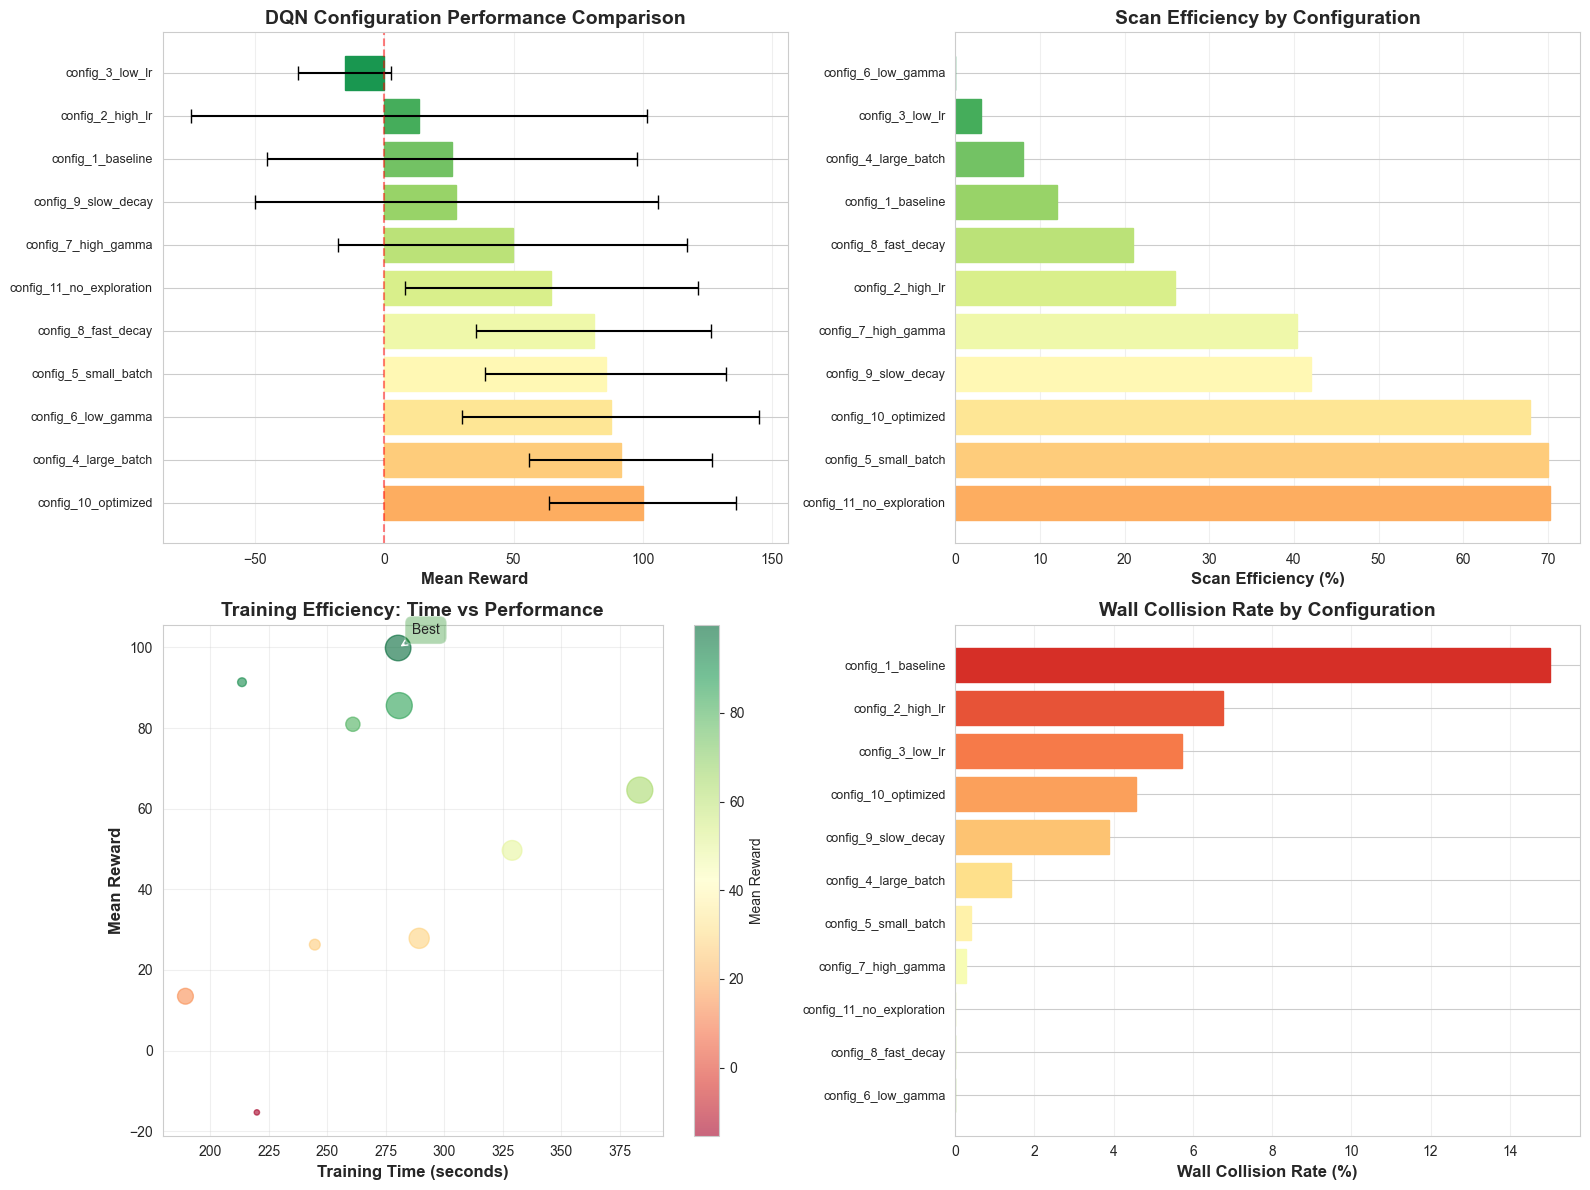

In [9]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9: Visualize Results - Comparison Plot
# ═══════════════════════════════════════════════════════════════════════
"""
Create comprehensive visualization of results (matching PPO format)
"""

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort by mean reward
results_sorted = results_df.sort_values('mean_reward', ascending=False)

# 1. Mean Reward Comparison
ax1 = axes[0, 0]
bars = ax1.barh(range(len(results_sorted)), results_sorted['mean_reward'], 
                xerr=results_sorted['std_reward'], capsize=5)
ax1.set_yticks(range(len(results_sorted)))
ax1.set_yticklabels(results_sorted['config_name'], fontsize=9)
ax1.set_xlabel('Mean Reward', fontsize=12, fontweight='bold')
ax1.set_title('DQN Configuration Performance Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Color bars by performance
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax1.grid(axis='x', alpha=0.3)

# 2. Scan Efficiency (matching PPO)
ax2 = axes[0, 1]
scan_eff_sorted = results_df.sort_values('scan_efficiency', ascending=False)
bars2 = ax2.barh(range(len(scan_eff_sorted)), scan_eff_sorted['scan_efficiency'] * 100)
ax2.set_yticks(range(len(scan_eff_sorted)))
ax2.set_yticklabels(scan_eff_sorted['config_name'], fontsize=9)
ax2.set_xlabel('Scan Efficiency (%)', fontsize=12, fontweight='bold')
ax2.set_title('Scan Efficiency by Configuration', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Color bars
colors2 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars2)))
for bar, color in zip(bars2, colors2):
    bar.set_color(color)

# 3. Training Time vs Performance
ax3 = axes[1, 0]
scatter = ax3.scatter(results_df['training_time'], results_df['mean_reward'], 
                     s=results_df['scan_efficiency']*500, alpha=0.6, 
                     c=results_df['mean_reward'], cmap='RdYlGn')
ax3.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
ax3.set_title('Training Efficiency: Time vs Performance', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# Add labels for best and worst
best_idx = results_df['mean_reward'].idxmax()
worst_idx = results_df['mean_reward'].idxmin()
ax3.annotate('Best', xy=(results_df.loc[best_idx, 'training_time'], 
                         results_df.loc[best_idx, 'mean_reward']),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Colorbar
plt.colorbar(scatter, ax=ax3, label='Mean Reward')

# 4. Wall Collision Rate (matching PPO)
ax4 = axes[1, 1]
wall_coll_sorted = results_df.sort_values('wall_collision_rate', ascending=True)
bars4 = ax4.barh(range(len(wall_coll_sorted)), wall_coll_sorted['wall_collision_rate'] * 100)
ax4.set_yticks(range(len(wall_coll_sorted)))
ax4.set_yticklabels(wall_coll_sorted['config_name'], fontsize=9)
ax4.set_xlabel('Wall Collision Rate (%)', fontsize=12, fontweight='bold')
ax4.set_title('Wall Collision Rate by Configuration', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Color bars (lower is better, so reverse colors)
colors4 = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(bars4)))
for bar, color in zip(bars4, colors4):
    bar.set_color(color)

plt.tight_layout()
plot_path = plots_dir / "dqn_comparison.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison plot saved to {plot_path}")
plt.show()

In [10]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 10: Detailed Analysis - Top 3 Configurations
# ═══════════════════════════════════════════════════════════════════════
"""
Detailed analysis of top 3 performing configurations (matching PPO format)
"""

print("\n" + "="*70)
print("TOP 3 CONFIGURATIONS - DETAILED ANALYSIS")
print("="*70)

top3 = results_df.nlargest(3, 'mean_reward')

for idx, (_, config) in enumerate(top3.iterrows(), 1):
    print(f"\n{'─'*70}")
    print(f"#{idx}: {config['config_name']}")
    print(f"{'─'*70}")
    print(f"Description: {config['description']}")
    print(f"Mean Reward: {config['mean_reward']:.2f} ± {config['std_reward']:.2f}")
    print(f"Avg Episode Length: {config['avg_episode_length']:.1f} steps")
    print(f"Wall Collision Rate: {config['wall_collision_rate']:.2%}")
    print(f"Scan Efficiency: {config['scan_efficiency']:.2%}")
    print(f"Avg Pickup Attempts: {config['avg_pickup_attempts']:.2f}")
    if config['avg_time_to_find_survivor'] is not None:
        print(f"Avg Time to Find Survivor: {config['avg_time_to_find_survivor']:.1f} steps")
    print(f"Survivor Found Count: {config['survivor_found_count']}/100")
    print(f"Training Time: {config['training_time']:.1f} seconds")
    
    if 'hyperparameters' in config and config['hyperparameters']:
        print(f"\nKey Hyperparameters:")
        hparams = config['hyperparameters']
        print(f"  - Learning Rate: {hparams.get('learning_rate', 'N/A')}")
        print(f"  - Batch Size: {hparams.get('batch_size', 'N/A')}")
        print(f"  - Buffer Size: {hparams.get('buffer_size', 'N/A')}")
        print(f"  - Gamma: {hparams.get('gamma', 'N/A')}")
        print(f"  - Exploration Fraction: {hparams.get('exploration_fraction', 'N/A')}")


TOP 3 CONFIGURATIONS - DETAILED ANALYSIS

──────────────────────────────────────────────────────────────────────
#1: config_10_optimized
──────────────────────────────────────────────────────────────────────
Description: Optimized - Balanced settings
Mean Reward: 99.85 ± 36.24
Avg Episode Length: 173.9 steps
Wall Collision Rate: 4.56%
Scan Efficiency: 67.93%
Avg Pickup Attempts: 0.70
Avg Time to Find Survivor: 15.5 steps
Survivor Found Count: 62/100
Training Time: 280.3 seconds

Key Hyperparameters:
  - Learning Rate: 0.0003
  - Batch Size: 64
  - Buffer Size: 50000
  - Gamma: 0.99
  - Exploration Fraction: 0.3

──────────────────────────────────────────────────────────────────────
#2: config_4_large_batch
──────────────────────────────────────────────────────────────────────
Description: Large Batch - Stable gradients
Mean Reward: 91.37 ± 35.21
Avg Episode Length: 68.9 steps
Wall Collision Rate: 1.41%
Scan Efficiency: 8.00%
Avg Pickup Attempts: 1.64
Avg Time to Find Survivor: 16.6 st

In [11]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 11: Export Summary for Report
# ═══════════════════════════════════════════════════════════════════════
"""
Create summary tables and statistics for the final report (matching PPO format)
"""

# Summary statistics
summary = {
    'total_configs': len(all_results),
    'best_config': best_config['config_name'],
    'best_mean_reward': float(best_config['mean_reward']),
    'best_scan_efficiency': float(best_config['scan_efficiency']),
    'best_wall_collision_rate': float(best_config['wall_collision_rate']),
    'avg_mean_reward': float(results_df['mean_reward'].mean()),
    'std_mean_reward': float(results_df['mean_reward'].std()),
    'avg_scan_efficiency': float(results_df['scan_efficiency'].mean()),
    'avg_wall_collision_rate': float(results_df['wall_collision_rate'].mean()),
    'total_training_time': float(results_df['training_time'].sum()),
}

# Save summary
summary_path = results_dir / "dqn_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)

print("\n" + "="*70)
print("DQN TRAINING SUMMARY")
print("="*70)
for key, value in summary.items():
    if 'rate' in key or 'efficiency' in key:
        if isinstance(value, float) and value < 1:
            print(f"{key.replace('_', ' ').title()}: {value:.2%}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")

print(f"\n✓ Summary saved to {summary_path}")


DQN TRAINING SUMMARY
Total Configs: 11
Best Config: config_10_optimized
Best Mean Reward: 99.84809999999997
Best Scan Efficiency: 67.93%
Best Wall Collision Rate: 4.56%
Avg Mean Reward: 55.60996363636363
Std Mean Reward: 37.875783141930484
Avg Scan Efficiency: 32.78%
Avg Wall Collision Rate: 3.46%
Total Training Time: 3008.6477990000003

✓ Summary saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\dqn_summary.json
